# **(PCA) of multidimensional points **


In this Jupyter notebook, we will be performing Principal Component Analysis (PCA) using the points provided is exp_2d_blobs using the easy approach.

### Accuracy with 2d data 

---

### Imports

In [32]:
from time import time

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
from sklearn.datasets import make_blobs
import pylab as pl
from sklearn.cluster import Birch, MiniBatchKMeans
from sklearn.mixture import GaussianMixture
# from robotikos.metric import IdentityFeature
# from robotikos.metric import (NormalizedSumSquaredDiffMetric,
#                               NormalizedSumAbsDiffMetric)
from thetan.theta import theta_g1, assign
from thetan.theta import distance_matrix as tdm
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, silhouette_score, fowlkes_mallows_score

import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

### Load 3d data from exp_2d_blobs test.py

In [33]:
verbose = True
show_thr = False
evaluation_thr = 0.1
radius = 4
n_local_samples = 30
blob_dis = 33
cluster_per_dim = 10
blob_dis = 15
cluster_x = 10
cluster_y = 10
cluster_z = 10
numberOfDimensions = 3
#measurement for centroid accuracy
#should be one 1000 clusters in 3dimensions 
xx = np.arange(-1*blob_dis*cluster_x//2, blob_dis*cluster_x//2, blob_dis)
yy = np.arange(-1*blob_dis*cluster_y//2, blob_dis*cluster_y//2, blob_dis)
zz = np.arange(-1*blob_dis*cluster_z//2, blob_dis*cluster_z//2, blob_dis)

xx, yy, zz = np.meshgrid(xx, yy, zz )
#of centers should be 1000
n_centres = np.hstack((np.ravel(xx)[:, np.newaxis],
                    np.ravel(yy)[:, np.newaxis], 
                    np.ravel(zz)[:,np.newaxis]))



gt_centroids = []
#here the number of dimensions is increased to 3 
# X = np.zeros((n_local_samples * n_centres.shape[0], 3))
X = np.zeros((n_local_samples * n_centres.shape[0], numberOfDimensions))
y = np.zeros((n_local_samples * n_centres.shape[0]), dtype=np.int16)
for i in range(n_centres.shape[0]):
    cpos = n_centres[i]

    local_X = cpos + np.random.normal(0, 1, (n_local_samples, numberOfDimensions))
    X[i * n_local_samples: (i + 1) * n_local_samples] = local_X
    y[i * n_local_samples: (i + 1) * n_local_samples] = i
    gt_centroids.append(local_X.mean(axis=0))

gt_centroids = np.array(gt_centroids)

points = X

labels = y
sz = len(n_centres)

centroids = gt_centroids
#put everything one line 
#goal for next week 
#plot X and y and attempt to plot up to 5 6 dimensions 
#create a function to return experiment set up 




print('Before shuffling')
print(points[:10])

points_idx = np.arange(np.shape(points)[0])
np.random.shuffle(points_idx)
new_points = np.zeros(np.shape(points))
new_labels = np.zeros(np.shape(labels))
for i, idx in zip(range(np.shape(points)[0]), points_idx):
    new_points[i] = points[idx]
    new_labels[i] = labels[idx]

points = new_points
labels = new_labels

print('After shuffling')
print(points[:10])
dfPoints = pd.DataFrame(points, columns = ['X','Y','Z'])



Before shuffling
[[-74.58235287 -76.43290062 -76.53826055]
 [-74.76814234 -73.42311003 -74.94774569]
 [-75.1749436  -74.99177196 -75.0960087 ]
 [-74.49116753 -75.57423415 -75.82150599]
 [-75.4568108  -75.44300085 -75.76497193]
 [-73.42497611 -74.40987505 -76.16386764]
 [-75.78245414 -73.28927494 -74.13436817]
 [-76.03201167 -76.06269162 -74.5797611 ]
 [-74.39330634 -75.71120815 -75.45504013]
 [-75.87336937 -75.49413763 -74.99359208]]
After shuffling
[[ 44.64802815   0.53912659  30.08620548]
 [-59.94597071  59.39736325 -28.60232046]
 [-44.70729736 -31.14250835 -29.93343141]
 [-60.14013431  31.62039133 -14.54295222]
 [-43.97072255  30.19829414 -31.30928631]
 [ 29.89224725  44.6630162  -76.84370025]
 [-44.72476015  29.52178328 -16.34796034]
 [-60.19345329 -77.097975   -44.92195614]
 [-16.17517453 -74.65859053 -46.96330895]
 [-74.77634267 -44.67443832  60.84428359]]


In [34]:
print(centroids)

[[-74.96716824 -74.86520898 -75.13463718]
 [-74.90332226 -75.02667271 -60.07518213]
 [-74.8773796  -74.83044981 -45.02872621]
 ...
 [ 59.87038337  60.11242028  29.87513245]
 [ 59.95542878  59.81579551  45.08768708]
 [ 60.17768174  60.01608614  59.52770914]]


# Performing kmeans++ and tm 

In [35]:
t1 = time()
kmeans = KMeans(n_clusters=np.prod(sz), init='k-means++', n_init=1,
                max_iter=300, tol=0.0001, random_state=0).fit(points)
t2 = time()

kmeans_time = t2 - t1
print('kmeans++ ', kmeans_time)

kcentroids = kmeans.cluster_centers_
klabels = kmeans.labels_
tmp = 0


#calculating theta centroids
theta = 6.0

t1 = time()
tcentroids, tlabels = theta_g1(points, theta=theta,)
t2 = time()

tm_time = t2 - t1
print('tm ', tm_time)

dfTCentroids = pd.DataFrame(tcentroids, columns = ['X','Y','Z'])
dfKCentroids = pd.DataFrame(kcentroids, columns = ['X','Y','Z'])
# print(dfTCentroids)
dftlabels = pd.DataFrame(tlabels)
dfPoints['tlabel'] = dftlabels
dfklabels = pd.DataFrame(klabels)
dfPoints['klabel'] = dfklabels
dfPoints.head()
print("tshape")
print(tcentroids.shape)
print("kshape")
print(kcentroids.shape)

kmeans++  1.888833999633789
tm  0.1944420337677002
tshape
(1000, 3)
kshape
(1000, 3)


### Input features

In [26]:
print(points)

[[ 15.33507285   0.34468708 -58.46721177]
 [ 29.03835033  28.05414467 -14.42413243]
 [-30.28894629 -45.02552902  30.74927332]
 ...
 [-31.54263383  31.56305992 -58.91224233]
 [ 61.04215158 -46.04076427 -14.73833804]
 [  0.57097846  44.66573322 -14.56611983]]


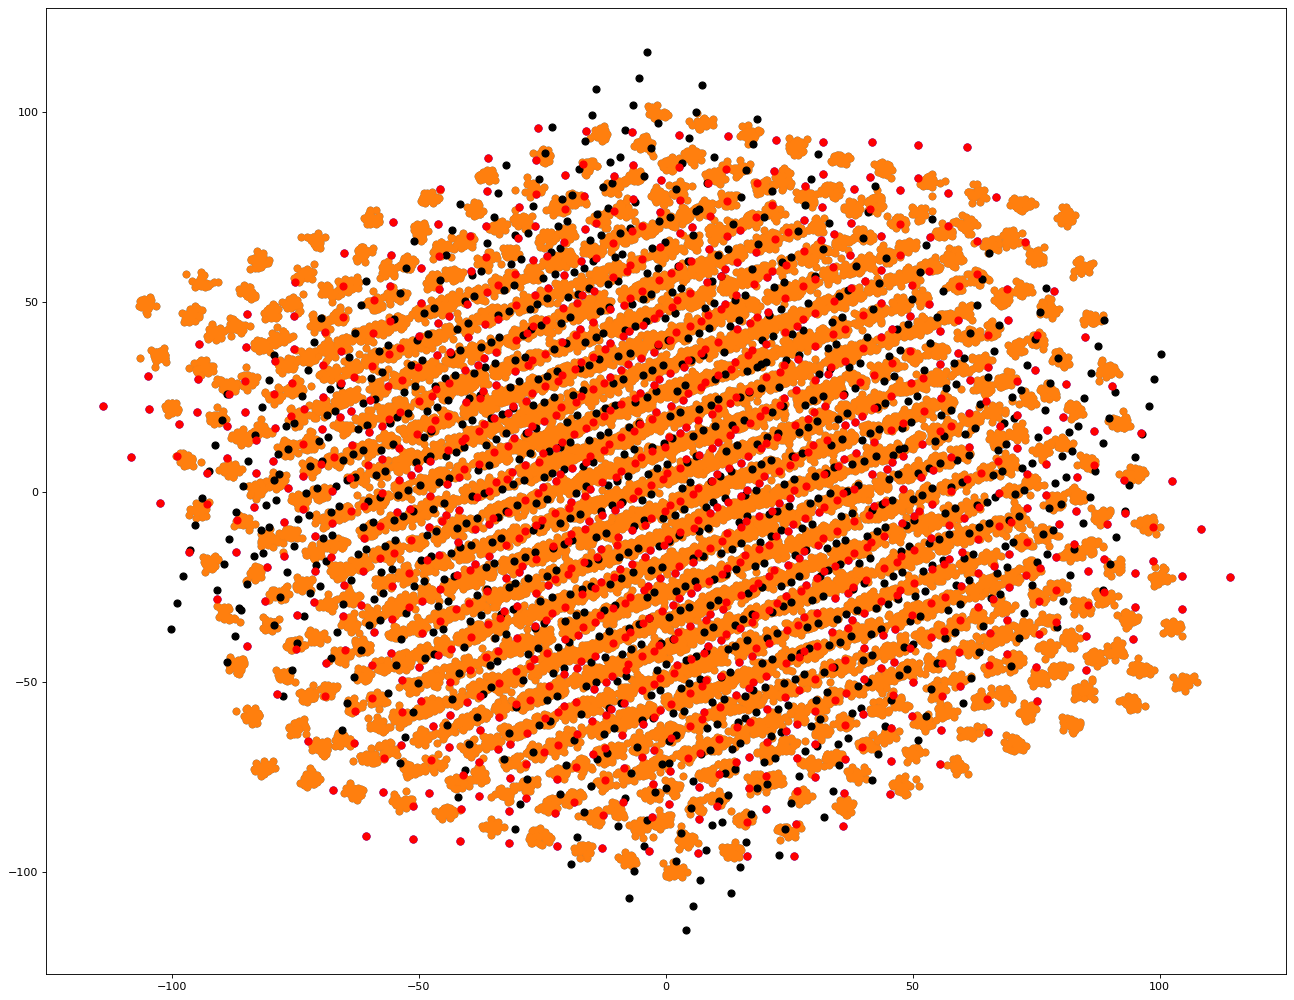

In [36]:
from matplotlib.pyplot import figure

figure(figsize=(20, 16), dpi=80)
#tcentroids
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
Xt = pca.fit_transform(points)
Tc = pca.fit_transform(tcentroids)
plot = plt.scatter(Xt[:,0], Xt[:,1])
plt.scatter(Tc[:,0] , Tc[:,1] , s = 40, color = 'blue')
# plt.legend(handles=plot.legend_elements()[0], labels=dfPoints['tlabels'])

#kcentroids
Kc = pca.fit_transform(kcentroids)
plot = plt.scatter(Xt[:,0], Xt[:,1])
plt.scatter(Kc[:,0] , Kc[:,1] , s = 40, color = 'black')
Ac = pca.fit_transform(centroids)

plt.scatter(Ac[:,0] , Ac[:,1] , s = 40, color = 'red')
plt.show()

#as the radius get smaller more errors will occur on km
#threshold is important for comparision, has to be smaller than theta 
# 4d data and get some accuracy measure of ground truth to calculated centroids

### Normalized Mutual Information (NMI) 
is a normalization of the Mutual Information (MI) score to scale the results between 0 (no mutual information) and 1 (perfect correlation). In this function, mutual information is normalized by some generalized mean of H(labels_true) and H(labels_pred)), defined by the average_method

### Silhouette Score
Compute the mean Silhouette Coefficient of all samples.

The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. The Silhouette Coefficient for a sample is (b - a) / max(a, b). To clarify, b is the distance between a sample and the nearest cluster that the sample is not a part of. Note that Silhouette Coefficient is only defined if number of labels is 2 <= n_labels <= n_samples - 1.

### Fowlkes_mallows_score
Measure the similarity of two clusterings of a set of points.

The Fowlkes-Mallows index (FMI) is defined as the geometric mean between of the precision and recall:

FMI = TP / sqrt((TP + FP) * (TP + FN))

In [39]:
print(klabels.shape)

(30000,)


In [37]:
from sklearn.metrics import normalized_mutual_info_score, silhouette_score, fowlkes_mallows_score

nmiScore = normalized_mutual_info_score(labels, klabels)
silScore = silhouette_score(points, klabels)
fmsScore = fowlkes_mallows_score(labels, klabels)

print(nmiScore)
print(silScore)
print(fmsScore)

0.9995720562233188
0.8310014057858857
0.996290448049339


In [38]:
from sklearn.metrics import normalized_mutual_info_score, silhouette_score, fowlkes_mallows_score

nmiScore = normalized_mutual_info_score(labels, tlabels)
silScore = silhouette_score(points, tlabels)
fmsScore = fowlkes_mallows_score(labels, tlabels)

print(nmiScore)
print(silScore)
print(fmsScore)

1.0
0.8352374131406545
1.0


### Accuracy

### Note that spatial.distance.cosine computes the distance, and not the similarity. So, you must subtract the value from 1 to get the similarity.

In [28]:
from scipy import spatial

#similarity for tlabels
simlarityTLabels = 1 - spatial.distance.cosine(labels, tlabels)
print('similarity for tlabels')
print(simlarityTLabels)
#similarity for tlabels
print('distance for tlabels')
distanceTLabels = spatial.distance.cosine(labels, tlabels)
print(distanceTLabels)
print('similarity for klabels')
simlarityKLabels = 1 - spatial.distance.cosine(labels, klabels)
print(simlarityKLabels)
print('distance for klabels')
distanceKLabels = spatial.distance.cosine(labels, klabels)
print(distanceKLabels)

similarity for tlabels
0.7404199609388622
distance for tlabels
0.2595800390611378
similarity for klabels
0.748748427264884
distance for klabels
0.251251572735116


### Clustering metrics used to evaluate predictions



### Homogeneity_score
A clustering result satisfies homogeneity if all of its clusters contain only data points which are members of a single class.

In [29]:
from sklearn.metrics.cluster import homogeneity_score
print('Homogeneity for tlabels')
homotlabels = homogeneity_score(labels, tlabels)
print(homotlabels)
print('Homogeneity for klabels')
homotlabels = homogeneity_score(labels, klabels)
print(homotlabels)


Homogeneity for tlabels
1.0
Homogeneity for klabels
0.9993979400086722


### Completeness_score

A clustering result satisfies completeness if all the data points that are members of a given class are elements of the same cluster.

In [30]:
from sklearn.metrics.cluster import completeness_score
print('completeness_score for tlabels')
homotlabels = completeness_score(labels, tlabels)
print(homotlabels)
print('completeness_score for klabels')
homotlabels = completeness_score(labels, klabels)
print(homotlabels)


completeness_score for tlabels
0.9999788438286761
completeness_score for klabels
0.999727104752122
